# Initialization

In [117]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
init_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stratification/active_users.csv')
df = init_df.copy().sample(50000) # we just copy our initial df to prevent changes in it

Here is an example of data you may have

Columns can be

*   Numerical. In my example: point_balance, checks_sum, count_checks
*   Categorical. Nominal(e.g. "country") or ordinal (e.g. "account_type")

In most cases we only want to know whether column numerical or not because too many unique values (usually they are numerical) make us too hard to select stratas (each new value will be a new strata) so we want to create bins for these cols in future

In [97]:
df.head(10)

,user_id,point_balance,arpu,count_checks,age,country,account_type
77758,8406749,47600.0,324.05,13,43,Finland,1
139353,6594556,43470.0,676.56,34,67,Malta,5
53778,6388972,299097.0,1000.70,13,70,France,1
184176,3204629,99687.0,1076.39,15,60,Bulgaria,5
187162,8253216,1987910.0,2509.75,38,33,Estonia,2
5803,4536576,118422.0,853.64,33,22,Estonia,1
86647,7098293,24898.0,1151.46,15,43,Hungary,5
190488,6072492,5635.0,207.20,12,19,Sweden,5
195850,1436580,12070.0,760.93,29,78,Italy,3
852,3550092,9962.0,225.23,10,45,Estonia,4


# Config

In [42]:
#Now we want to specify our cols

"""
here you select a column you actually want to stratify
it could be:
  user_id if you splitting your users
  shop_id e.g. you have a lot of shops and you want to test some changes in it
  anything you actually want to test on :)
"""

user_id_col = 'user_id'

"""
as strata is a set of unique values
we need to bin numeric cols, otherwise 
the number of stratas will be too high 
and it will be impossible to split between them
(u can also mention here other num cols you want to bin)
"""

#cols_to_bin = ['point_balance', 'arpu', 'count_checks', 'age']
cols_to_bin = ['arpu']

"""
for some users set of columns may be too unique
e.g. we have only 5 users  with low check_sum
and high count_checks. In that case we should
define minimal size of strata (e.g. 10 users) 
and if some users are too unique (e.g. <10 users for such group)
we just gonna call them outliers and split
randomly between our groups (control and treatment)
"""
min_strata_size = 10

# Main functions

In [116]:
def bin_data(df_to_bin : pd.DataFrame, bin_cols : list) -> pd.DataFrame:
  bin_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high'] # u can change it, also changing q param below
  #bin_labels = ['Low', 'Medium', 'High']
  for col in bin_cols:
    df_to_bin[col+'_bin'] = pd.qcut(df_to_bin[col],q = 5, labels = bin_labels)
  return df_to_bin

In [44]:
def asssign_stratas(df_to_strat : pd.DataFrame, strat_cols : list) -> pd.DataFrame:
  """
  function to assign stratas for our dataframe 
  cols_to_strat defines by which columns you want to create stratas
  if you pass too much columns it would be hard to select stratas
  (too many unique values)
  """
  strat_cols = set([col+'_bin' if col+'_bin' in strat_cols else col for col in strat_cols])
  #just selecting cols to strat from our df (cols binned previously without original num cols + categorical cols)
  stratas_df = df_to_strat[strat_cols].drop_duplicates()

  stratas_df['strata'] = np.arange(1,len(stratas_df)+1) # we leave 0 value for outliers
  strated_df = pd.merge(df_to_strat,stratas_df, on = list(stratas_df.drop(columns = 'strata').columns), how = 'inner')

  unsplitted_stratas = list(strated_df.groupby('strata').filter(lambda x: x['user_id'].count() < min_strata_size)['strata'].unique())
  #here we collect stratas which has number of user_id lower than our min_strata_size
  strated_df['strata'] = np.where(strated_df['strata'].isin(unsplitted_stratas), 0,strated_df['strata'])
  #changing strata to 0 value if the number of user_id per strata ower than our min_strata_size
  return strated_df

In [45]:
def split_data(df : pd.DataFrame) -> pd.DataFrame :
  # function for equal data split between control and treatment according to stratas
  grouped = df.groupby('strata')
  test = grouped.apply(lambda x: x.sample(frac=0.5))['user_id'].tolist()
  df['group_name'] = np.where(df['user_id'].isin(test), 'treatment','control')
  return df

In [46]:
def make_stratify_sample(df : pd.DataFrame, bin_cols : list) -> pd.DataFrame :
  # function to combine all steps and create stratified sample
  df = bin_data(df, bin_cols)
  df = asssign_stratas(df, list(df.drop(columns = 'user_id').columns))
  df = split_data(df)
  return df

In [47]:
def make_random_sample(df: pd.DataFrame) -> pd.DataFrame:
  # function for random and equal data split between control and treatment
  test = df.sample(frac = 0.5)['user_id'].tolist()
  df['group_name'] = np.where(df['user_id'].isin(test), 'treatment','control')
  return df

In [49]:
def write_file(filename : str, list : list) -> None:
  # function for writing and reading lists when you leave collab 
  # with long and many iterative tests
  path = '/content/drive/MyDrive/Colab Notebooks/stratification'
  textfile = open(f'{path}/{filename}.txt', "w")
  for element in list:
    textfile.write(str(element)+'\n')
  textfile.close()

def read_file(filename : str) -> list:
  path = '/content/drive/MyDrive/Colab Notebooks/stratification'
  textfile = open(f'{path}/{filename}.txt', "r")
  result = textfile.readlines()
  result = [float(x.strip()) for x in result]
  return result

# Checking random and stratify samples

In [110]:
stratify_deltas = []
random_deltas = []
for _ in tqdm(range(100)):
  df = init_df.copy()[['user_id','arpu']]

  df = make_stratify_sample(df, cols_to_bin)
  strat_control_mean = float(df[df.group_name == 'control'].agg({'arpu':'mean'}))
  strat_test_mean = float(df[df.group_name == 'treatment'].agg({'arpu':'mean'}))
  stratify_deltas.append(strat_test_mean-strat_control_mean)
  
  df = make_random_sample(df)
  strat_control_mean = float(df[df.group_name == 'control'].agg({'arpu':'mean'}))
  strat_test_mean = float(df[df.group_name == 'treatment'].agg({'arpu':'mean'}))
  random_deltas.append(strat_test_mean-strat_control_mean)

100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


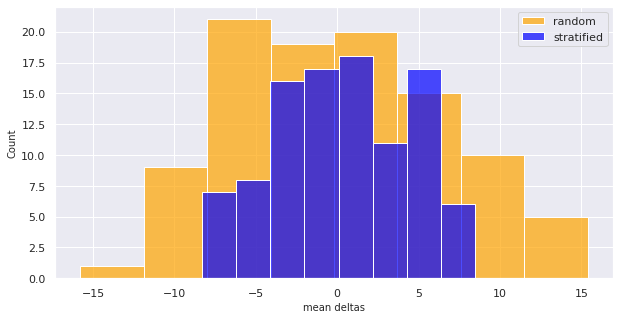

In [198]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
hist1 = sns.histplot(random_deltas, color = 'orange', alpha = 0.7)
hist2 = sns.histplot(stratify_deltas, color = 'blue', alpha = 0.7)
hist1.set_xlabel("mean deltas", fontsize = 10)
hist1.set_ylabel("Count", fontsize = 10)
plt.legend(labels=["random","stratified"])
plt.show()

In [111]:
print('',round(np.mean(random_deltas),3),'- random\n',round(np.mean(stratify_deltas),3),'- stratify')

 0.174 - random
 0.23 - stratify


In [199]:
print('',round(np.var(random_deltas),3),'- random\n',round(np.var(stratify_deltas),3),'- stratify')

 43.303 - random
 17.279 - stratify


# Making AA and AB tests for random and stratify sampling

In [92]:
def get_ttest_res(a_sample, b_sample, alpha = 0.05):
  _, p_val = ttest_ind(a_sample, b_sample)
  return round(p_val, 10)

stratify_sign_aa = []
random_sign_aa = []

stratify_sign_ab = []
random_sign_ab = []
effect = 50

for _ in tqdm(range(1000)):
  df = init_df.copy()[['user_id','arpu']].sample(20000)
  df = make_stratify_sample(df, cols_to_bin)
  aa_pval = get_ttest_res(df[df.group_name == 'control']['arpu'],
                      df[df.group_name == 'treatment']['arpu'])
  ab_pval = get_ttest_res(df[df.group_name == 'control']['arpu'],
                      df[df.group_name == 'treatment']['arpu']+effect)
  stratify_sign_aa.append(aa_pval < 0.05)
  stratify_sign_ab.append(ab_pval >= 0.05)
  
  df = make_random_sample(df)
  aa_pval = get_ttest_res(df[df.group_name == 'control']['arpu'],
                      df[df.group_name == 'treatment']['arpu'])
  ab_pval = get_ttest_res(df[df.group_name == 'control']['arpu'],
                      df[df.group_name == 'treatment']['arpu']+effect)
  random_sign_aa.append(aa_pval < 0.05)
  random_sign_ab.append(ab_pval >= 0.05)

100%|██████████| 1000/1000 [01:34<00:00, 10.53it/s]


In [93]:
print(' 1st type errors probability\n',np.mean(random_sign_aa),'- random\n',np.mean(stratify_sign_aa),'- stratify')

 1st type errors probability
 0.048 - random
 0.003 - stratify


In [94]:
print(' 2nd type errors probability\n',np.mean(random_sign_ab),'- random\n',np.mean(stratify_sign_ab),'- stratify')

 2nd type errors probability
 0.187 - random
 0.093 - stratify


# Example of stratifying by many cols 
# (All features will be disturbed evenly between two groups)

In [108]:
df = init_df.copy()
df = make_stratify_sample(df, ['point_balance', 'arpu', 'count_checks', 'age'])
df

,user_id,point_balance,arpu,count_checks,age,country,account_type,point_balance_bin,arpu_bin,count_checks_bin,age_bin,strata,group_name
0,1826697,275808.0,1180.62,20,85,Spain,1,High,High,Medium,Very high,0,treatment
1,7573764,217242.0,1319.57,18,74,Spain,1,High,High,Medium,Very high,0,treatment
2,6801282,235376.0,1221.91,22,84,Spain,1,High,High,Medium,Very high,0,treatment
3,8478104,212300.0,1339.56,18,85,Spain,1,High,High,Medium,Very high,0,treatment
4,7979360,5984.0,656.28,24,26,Greece,5,Very low,Low,High,Very low,0,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,7135808,394240.0,677.29,7,25,Poland,5,Very high,Low,Very low,Very low,0,control
199996,9571444,25917.0,972.20,25,79,Cyprus,3,Low,Medium,High,Very high,0,control
199997,7660118,40439.0,1847.44,81,49,Estonia,2,Low,Very high,Very high,Medium,0,treatment
199998,2611044,122512.0,1542.98,21,18,Greece,2,High,High,Medium,Very low,0,treatment


As we see - too many people were asssigned to outlier strata (zero value). 
That means, that amount of people with theese set of features were too low (< min_strata_size).

Our want to make group equal with many features played bad joke with us. Too many unique values made them being outlier, which means very big ( amount more than a half of a sample) of users would be stratified randomly (which not we really what we want from stratify sampling).


In [109]:
df.groupby('strata').agg({'user_id':'count','arpu':'mean'})

,user_id,arpu
strata,,
0,121277,1106.254945
3,12,297.182500
5,19,587.142105
7,10,2607.785000
10,13,351.223077
...,...,...
33550,12,326.197500
33776,10,3145.415000
33788,10,935.597000
